In [2]:
import pandas as pd

df_raw = pd.read_csv("/content/raw_dataset.csv")


df_raw.head(10)


,Name,Age,Salary,Department
0,DAVID,36.0,45795.0,finance
1,grace,27.0,30860.0,operations
2,DAVID,54.0,106820.0,marketing
3,HEIDI,NaN,NaN,OPERATIONS
4,EVE,52.0,NaN,IT
5,alice,24.0,1000000.0,it
6,charlie,58.0,67194.0,it
7,grace,47.0,117498.0,IT
8,FRANK,26.0,74131.0,MARKETING
9,EVE,28.0,90263.0,hr


Python cleaning pipeline

In [26]:
import numpy as np

# 3.1 Missing value imputation
def impute_missing_values(df):
    """Fill missing values: numeric -> median, categorical -> mode"""
    for col in df.select_dtypes(include=np.number).columns:
        df[col].fillna(df[col].median(), inplace=True)
    for col in df.select_dtypes(include='object').columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

In [27]:
# 3.2 Text normalization
def normalize_text(df):
    """Strip spaces, lowercase all text"""
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.strip().str.lower()
    return df

# 3.3 Outlier detection using Z-score
def detect_outliers(df, z_thresh=3):
    """Return dictionary of outliers per numeric column using Z-score"""
    outliers = {}
    for col in df.select_dtypes(include=np.number).columns:
        mean, std = df[col].mean(), df[col].std()
        outliers[col] = df[(df[col] - mean).abs() > z_thresh * std]
    return outliers

In [28]:
def flag_anomalies(df):
    """Flag negative ages and extremely high salaries as anomalies"""
    df["Anomaly"] = False
    df.loc[df["Age"] < 0, "Anomaly"] = True
    df.loc[df["Salary"] > 300000, "Anomaly"] = True
    return df

In [29]:
# Make a copy to preserve raw data
df_cleaned = df_raw.copy()

# Impute missing values
df_cleaned = impute_missing_values(df_cleaned)

# Normalize text
df_cleaned = normalize_text(df_cleaned)

# Detect outliers
outliers = detect_outliers(df_cleaned)

# Flag anomalies
df_cleaned = flag_anomalies(df_cleaned)

# Display first 10 rows after cleaning
df_cleaned.head(10)



/tmp/ipython-input-2700033872.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-2700033872.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

,Name,Age,Salary,Department,Anomaly
0,david,36.0,45795.0,finance,False
1,grace,27.0,30860.0,operations,False
2,david,54.0,106820.0,marketing,False
3,heidi,43.0,86886.0,operations,False
4,eve,52.0,86886.0,it,False
5,alice,24.0,1000000.0,it,True
6,charlie,58.0,67194.0,it,False
7,grace,47.0,117498.0,it,False
8,frank,26.0,74131.0,marketing,False
9,eve,28.0,90263.0,hr,False


In [7]:

df_cleaned.to_csv('pipeline_cleaned.csv', index=False)

#
from google.colab import files
files.download('pipeline_cleaned.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Before cleaning
print("Before Cleaning - Missing Values:\n", df_raw.isna().sum())

# After cleaning
print("\nAfter Cleaning - Missing Values:\n", df_cleaned.isna().sum())

# Outliers detected
print("\nOutliers detected per column:")
for col, df_out in outliers.items():
    print(f"{col}: {len(df_out)}")

# Number of anomalies flagged
print("\nTotal anomalies flagged:", df_cleaned["Anomaly"].sum())


Before Cleaning - Missing Values:
 Name           0
Age           13
Salary         9
Department     0
dtype: int64

After Cleaning - Missing Values:
 Name          0
Age           0
Salary        0
Department    0
Anomaly       0
dtype: int64

Outliers detected per column:
Age: 1
Salary: 1

Total anomalies flagged: 2


In [35]:
print(" Missing Values Comparison ")

missing_comparison = pd.DataFrame({
    "Before_Cleaning": df_raw.isna().sum(),
    "After_Cleaning": df_cleaned.isna().sum()
})

print(missing_comparison)

 Missing Values Comparison 
            Before_Cleaning  After_Cleaning
Age                    13.0               0
Anomaly                 NaN               0
Department              0.0               0
Name                    0.0               0
Salary                  9.0               0


In [33]:
print("\n Numeric Summary Statistics (Before vs After) ")

numeric_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

summary_stats = pd.concat(
    [
        df_raw[numeric_cols].describe().T.add_prefix("Before_"),
        df_cleaned[numeric_cols].describe().T.add_prefix("After_")
    ],
    axis=1
)

print(summary_stats)


 Numeric Summary Statistics (Before vs After) 
        Before_count  Before_mean     Before_std  Before_min  Before_25%  \
Age             87.0     40.00000      13.470899        -5.0        27.5   
Salary          91.0  90240.56044  100314.494076     30769.0     57175.5   

        Before_50%  Before_75%  Before_max  After_count  After_mean  \
Age           43.0        51.0        59.0        100.0       40.39   
Salary     86886.0    102170.5   1000000.0        100.0    89938.65   

           After_std  After_min  After_25%  After_50%  After_75%  After_max  
Age        12.596212       -5.0      29.50       43.0       51.0       59.0  
Salary  95650.983703    30769.0   62342.25    86886.0    99912.0  1000000.0  


In [40]:
print("\nOutliers Detected Per Column")

outlier_summary = {}
for col, df_out in outliers.items():
    outlier_summary[col] = len(df_out)

outlier_summary_df = pd.DataFrame.from_dict(
    outlier_summary, orient="index", columns=["Outliers_Detected"]
)

print(outlier_summary_df)


Outliers Detected Per Column
        Outliers_Detected
Age                     1
Salary                  1


In [39]:
print("\nTotal outliers detected:", outlier_summary_df["Outliers_Detected"].sum())



Total outliers detected: 2


In [37]:
print("\nAnomaly Flagging Summary ")

total_rows = len(df_cleaned)
anomalies = df_cleaned["Anomaly"].sum()

print(f"Total records            : {total_rows}")
print(f"Total anomalies flagged  : {anomalies}")
print(f"Percentage anomalies     : {(anomalies / total_rows) * 100:.2f}%")



Anomaly Flagging Summary 
Total records            : 100
Total anomalies flagged  : 2
Percentage anomalies     : 2.00%


Comparision of raw dataset vs openrefinedataset vs pipelined dataset

Missing Values Comparison:
              Raw  Pipeline  OpenRefine
Age         13.0         0        13.0
Anomaly      NaN         0         NaN
Department   0.0         0         0.0
Name         0.0         0         0.0
Salary       9.0         0         9.0


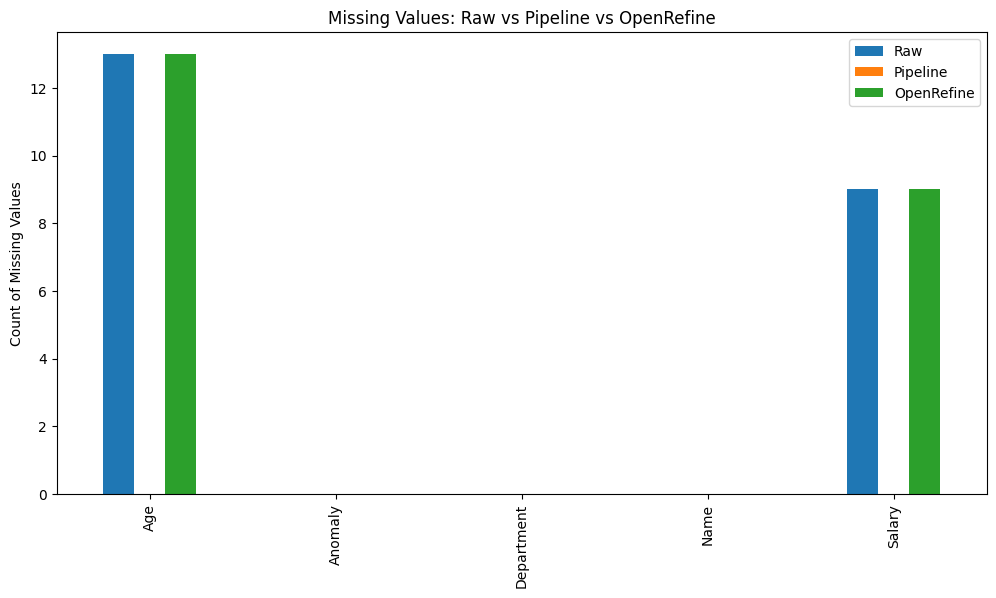


Numeric Columns Comparison:
         Pipeline_mean  OpenRefine_mean  Pipeline_std  OpenRefine_std
Age             40.39         40.00000     12.596212       13.470899
Salary       89938.65      90240.56044  95650.983703   100314.494076


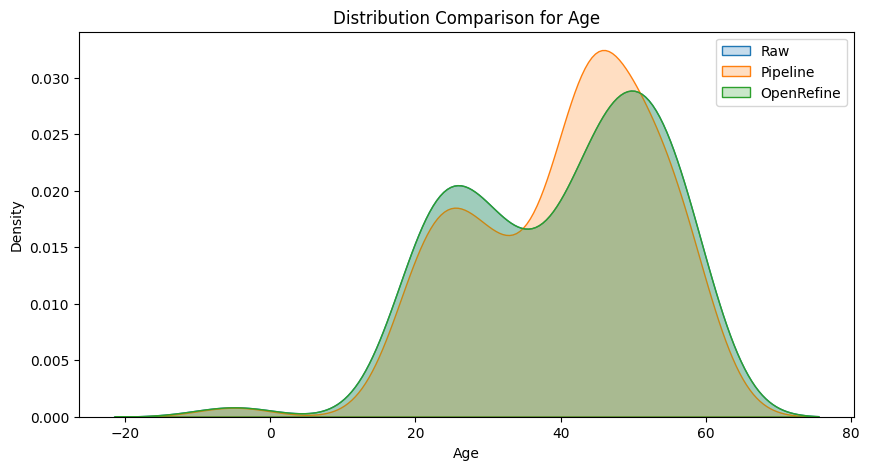

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
raw_df = pd.read_csv('/content/raw_dataset.csv')
pipeline_df = pd.read_csv('/content/pipeline_cleaned.csv')
openrefine_df = pd.read_csv('/content/raw-datset-openrefine.csv')

#  Missing Values Comparison
missing_summary = pd.DataFrame({
    'Raw': raw_df.isna().sum(),
    'Pipeline': pipeline_df.isna().sum(),
    'OpenRefine': openrefine_df.isna().sum()
})
print("Missing Values Comparison:\n", missing_summary)

# Visualize missing values
missing_summary.plot(kind='bar', figsize=(12,6))
plt.title('Missing Values: Raw vs Pipeline vs OpenRefine')
plt.ylabel('Count of Missing Values')
plt.show()

# Numeric Column Comparison (summary stats)
numeric_cols = pipeline_df.select_dtypes(include=['float','int']).columns
numeric_comparison = pd.DataFrame({
    'Pipeline_mean': pipeline_df[numeric_cols].mean(),
    'OpenRefine_mean': openrefine_df[numeric_cols].mean(),
    'Pipeline_std': pipeline_df[numeric_cols].std(),
    'OpenRefine_std': openrefine_df[numeric_cols].std()
})
print("\nNumeric Columns Comparison:\n", numeric_comparison)

# Outlier Flag Comparison (if you flagged outliers in pipeline)
outlier_cols = [col for col in pipeline_df.columns if '_outlier' in col]
if outlier_cols:
    outlier_summary = pd.DataFrame({
        'Pipeline_outliers': pipeline_df[outlier_cols].sum(),
        'OpenRefine_outliers': openrefine_df[outlier_cols].sum() if all(col in openrefine_df.columns for col in outlier_cols) else 0
    })
    print("\nOutlier Comparison:\n", outlier_summary)

#  Visual Comparison for a sample numeric column
sample_col = numeric_cols[0]  # pick first numeric column
plt.figure(figsize=(10,5))
sns.kdeplot(raw_df[sample_col], label='Raw', fill=True)
sns.kdeplot(pipeline_df[sample_col], label='Pipeline', fill=True)
sns.kdeplot(openrefine_df[sample_col], label='OpenRefine', fill=True)
plt.title(f'Distribution Comparison for {sample_col}')
plt.xlabel(sample_col)
plt.legend()
plt.show()


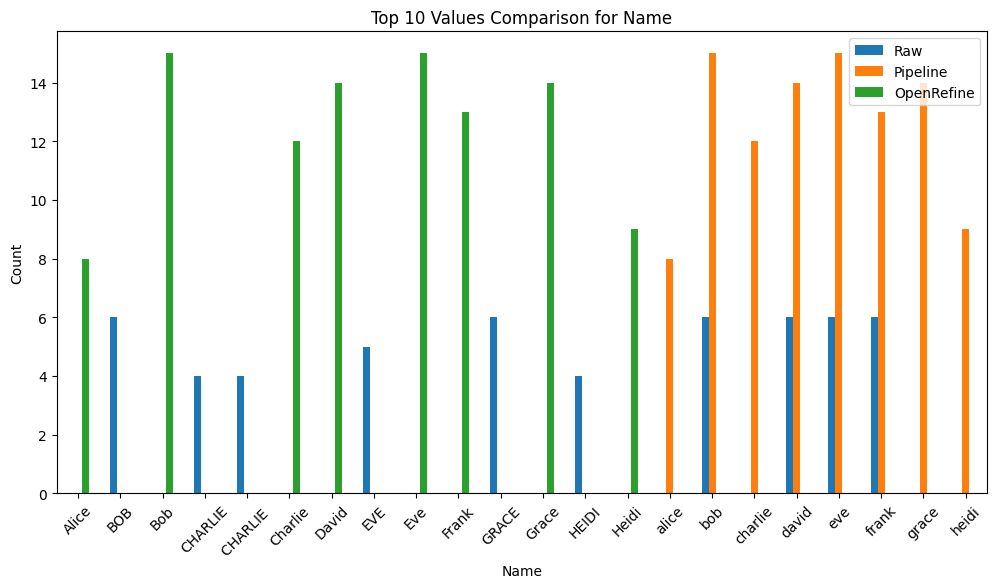

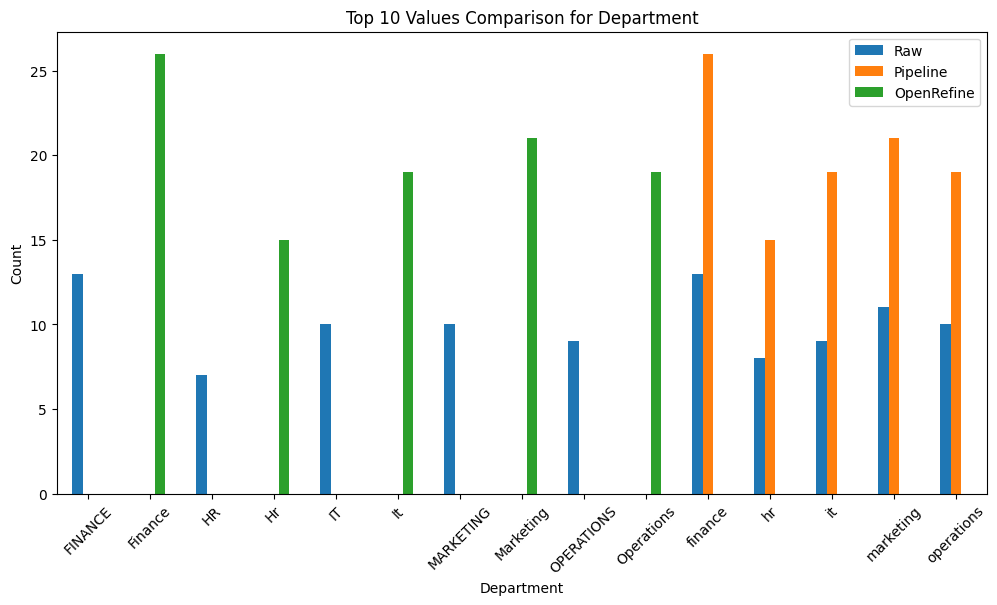

In [11]:
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

for col in categorical_cols:
    comparison_df = pd.DataFrame({
        'Raw': raw_df[col].value_counts().head(10),
        'Pipeline': df_cleaned[col].value_counts().head(10),
        'OpenRefine': openrefine_df[col].value_counts().head(10)
    }).fillna(0)

    comparison_df.plot(kind='bar', figsize=(12,6))
    plt.title(f'Top 10 Values Comparison for {col}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
